<a href="https://colab.research.google.com/github/Lada496/ielts-score-prediction-tensorflow/blob/main/IELTS_WRITING_SCORING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

End-to-end multi-class IELTS Scoring Classification

This notebook builds an end-to-end sentence classifier using TnsforFlow 2.0 and TensorFlow Hub.

## 1. Problem
Predicting the IELTS Writing score of an answer text.

## 2. Data
The data we're using from Kaggle's IELTS Writing Scored Essays Dataset: https://www.kaggle.com/datasets/mazlumi/ielts-writing-scored-essays-dataset/data

## 3. Evaluation
The evaluation is a test with prediction probabilities from each test answer data.

## 4. Features
Some information about the data:
- We're dealing with text
- There are Question, Essay and Overall

In [250]:
# Install necessary packages
!pip install tensorflow transformers scikit-learn pandas matplotlib kaggle

In [251]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [252]:
%cd /content/drive/MyDrive/IELTS_Scoring/

/content/drive/MyDrive/IELTS_Scoring


# Data

In [313]:
# Load data
import pandas as pd
df = pd.read_csv('data/ielts_writing_dataset.csv')
df.head()

,Task_Type,Question,Essay,Examiner_Commen,Task_Response,Coherence_Cohesion,Lexical_Resource,Range_Accuracy,Overall
0,1,The bar chart below describes some changes abo...,"Between 1995 and 2010, a study was conducted r...",NaN,NaN,NaN,NaN,NaN,5.5
1,2,Rich countries often give money to poorer coun...,Poverty represents a worldwide crisis. It is t...,NaN,NaN,NaN,NaN,NaN,6.5
2,1,The bar chart below describes some changes abo...,The left chart shows the population change hap...,NaN,NaN,NaN,NaN,NaN,5.0
3,2,Rich countries often give money to poorer coun...,Human beings are facing many challenges nowada...,NaN,NaN,NaN,NaN,NaN,5.5
4,1,The graph below shows the number of overseas v...,Information about the thousands of visits from...,NaN,NaN,NaN,NaN,NaN,7.0


In [254]:
df_task1 = df[df['Task_Type'] == 1]

In [255]:
len(df_task1)

642

In [256]:
df_task2 = df[df['Task_Type'] == 2]

In [257]:
len(df_task2)

793

In [258]:
# Store task2 only dataset
df_task2.to_csv('data/ielts_writing_dataset_task2.csv', index=False)

In [259]:
# Load task2 only dataset
df_task2 = pd.read_csv('data/ielts_writing_dataset_task2.csv')
df_task2.head()

,Task_Type,Question,Essay,Examiner_Commen,Task_Response,Coherence_Cohesion,Lexical_Resource,Range_Accuracy,Overall
0,2,Rich countries often give money to poorer coun...,Poverty represents a worldwide crisis. It is t...,NaN,NaN,NaN,NaN,NaN,6.5
1,2,Rich countries often give money to poorer coun...,Human beings are facing many challenges nowada...,NaN,NaN,NaN,NaN,NaN,5.5
2,2,Some countries achieve international sports by...,Whether countries should only invest facilitie...,NaN,NaN,NaN,NaN,NaN,6.5
3,2,Some countries achieve international sports by...,"Sports is an essential part to most of us , so...",NaN,NaN,NaN,NaN,NaN,5.5
4,2,Some countries achieve international sports by...,International sports events require the most w...,NaN,NaN,NaN,NaN,NaN,9.0


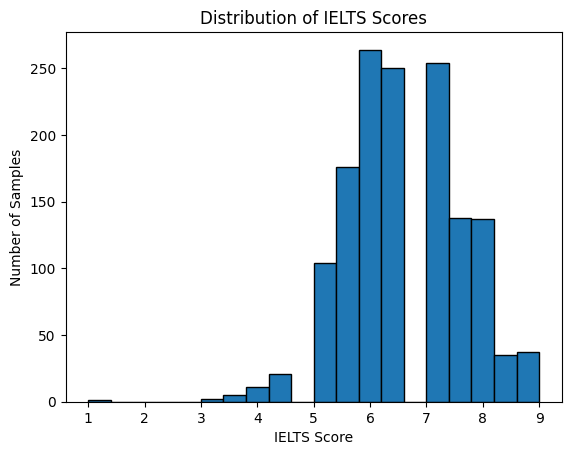

In [260]:
import matplotlib.pyplot as plt

plt.hist(df['Overall'], bins=20, edgecolor='k')
plt.xlabel('IELTS Score')
plt.ylabel('Number of Samples')
plt.title('Distribution of IELTS Scores')
plt.show()

In [316]:
# Import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Preprocess Data

In [317]:
df = df[['Question', 'Essay', 'Overall']].copy()
df['text'] = df['Question'] + ' ' + df['Essay']

In [322]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)      # remove digits
    return text

In [323]:
df['text'] = df['text'].apply(clean_text)

In [324]:
# Train/Val/Test Split
X_temp, X_test, y_temp, y_test = train_test_split(
    df['text'], df['Overall'], test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

In [325]:
# y_train and y_val are your original IELTS scores (3.0, 3.5, 4.0 ... 9.0)
le = LabelEncoder()
le.fit(np.concatenate([y_train, y_val, y_test]))  # fit on all possible scores

LabelEncoder()

In [326]:
y_train_enc = le.transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

num_classes = len(le.classes_)
print("Classes:", le.classes_)

Classes: [1.  3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5 9. ]


In [327]:
# Compute class weights for imbalance
class_weights_dict = dict(zip(
    np.unique(y_train_enc),
    class_weight.compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
))
print("Class weights:", class_weights_dict)

Class weights: {np.int64(0): np.float64(61.5), np.int64(1): np.float64(30.75), np.int64(2): np.float64(20.5), np.int64(3): np.float64(10.25), np.int64(4): np.float64(4.392857142857143), np.int64(5): np.float64(0.9461538461538461), np.int64(6): np.float64(0.6089108910891089), np.int64(7): np.float64(0.3704819277108434), np.int64(8): np.float64(0.4270833333333333), np.int64(9): np.float64(0.3967741935483871), np.int64(10): np.float64(0.75), np.int64(11): np.float64(0.7784810126582279), np.int64(12): np.float64(3.236842105263158), np.int64(13): np.float64(2.5625)}


In [328]:
# Tokenize text
vocab_size = 10000
max_len = 200
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [329]:
# Tokenize
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len, padding='post')
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_len, padding='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len, padding='post')

# Build Model

In [330]:
# Define ±0.5 accuracy metric ---
def within_half_accuracy(y_true, y_pred):
    y_pred_classes = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)
    correct = tf.abs(y_true - y_pred_classes) <= 1  # ±1 class ≈ ±0.5 score
    return tf.reduce_mean(tf.cast(correct, tf.float32))

In [331]:
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(128),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [332]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', within_half_accuracy]
)

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [333]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train_seq, y_train_enc,
    validation_data=(X_val_seq, y_val_enc),
    epochs=20,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 927ms/step - accuracy: 0.0602 - loss: 2.7138 - within_half_accuracy: 0.1771 - val_accuracy: 0.1289 - val_loss: 2.6296 - val_within_half_accuracy: 0.2685
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 954ms/step - accuracy: 0.1369 - loss: 2.6998 - within_half_accuracy: 0.2271 - val_accuracy: 0.0314 - val_loss: 2.6514 - val_within_half_accuracy: 0.1537
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 725ms/step - accuracy: 0.0756 - loss: 2.5322 - within_half_accuracy: 0.1408 - val_accuracy: 0.0836 - val_loss: 2.6213 - val_within_half_accuracy: 0.1258
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 580ms/step - accuracy: 0.1059 - loss: 2.0410 - within_half_accuracy: 0.1675 - val_accuracy: 0.1080 - val_loss: 2.5813 - val_within_half_accuracy: 0.1920
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 530ms/step - accuracy: 0.1918 - loss: 2.2829 - within_half_accuracy: 0.2706 - val_accuracy: 0.1115 - val_loss: 2.6231 - val_within_half_accuracy: 0.1775
Epoch 6/20
27/27 ━━━━━━━━

# Evaluate

In [339]:
# Predict probabilities
y_pred_prob = model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_pred_scores = le.inverse_transform(y_pred_classes)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


In [340]:
# Compute ±0.5 accuracy
within_half = np.abs(y_pred_scores - y_test.values) <= 0.5
half_accuracy = np.mean(within_half)
print(f"±0.5 Accuracy on Test Set: {half_accuracy*100:.2f}%")

±0.5 Accuracy on Test Set: 51.92%


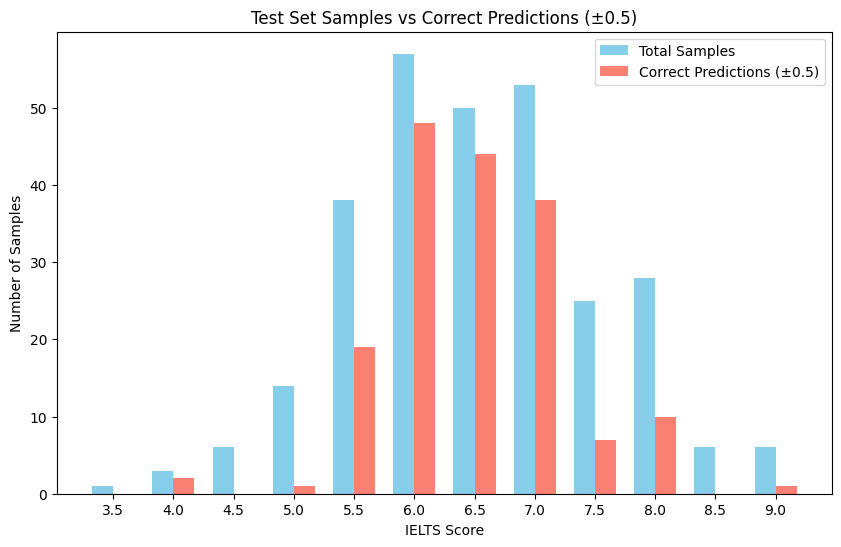

In [351]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Convert X_test to sequences and predict
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len, padding='post')

# Predict probabilities for all test samples at once
y_pred_prob = model.predict(X_test_seq, verbose=0)  # shape: (num_samples, num_classes)

# Weighted average of class scores for continuous prediction
y_pred_scores = np.dot(y_pred_prob, le.classes_)

# Round to nearest 0.5
y_pred_scores_rounded = np.round(y_pred_scores * 2) / 2

# True scores
y_true_scores = y_test.values

# ompute ±0.5 correctness per sample
correct = np.abs(y_pred_scores_rounded - y_true_scores) <= 0.5

# Count total samples and correct predictions per score
scores = sorted(np.unique(y_true_scores))  # e.g., [4.0, 4.5, ..., 9.0]
total_counts = [np.sum(y_true_scores == s) for s in scores]
correct_counts = [np.sum((y_true_scores == s) & correct) for s in scores]

# Plot the bar chart
x = np.arange(len(scores))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, total_counts, width, label='Total Samples', color='skyblue')
ax.bar(x + width/2, correct_counts, width, label='Correct Predictions (±0.5)', color='salmon')

ax.set_xlabel('IELTS Score')
ax.set_ylabel('Number of Samples')
ax.set_title('Test Set Samples vs Correct Predictions (±0.5)')
ax.set_xticks(x)
ax.set_xticklabels(scores)
ax.legend()
plt.show()



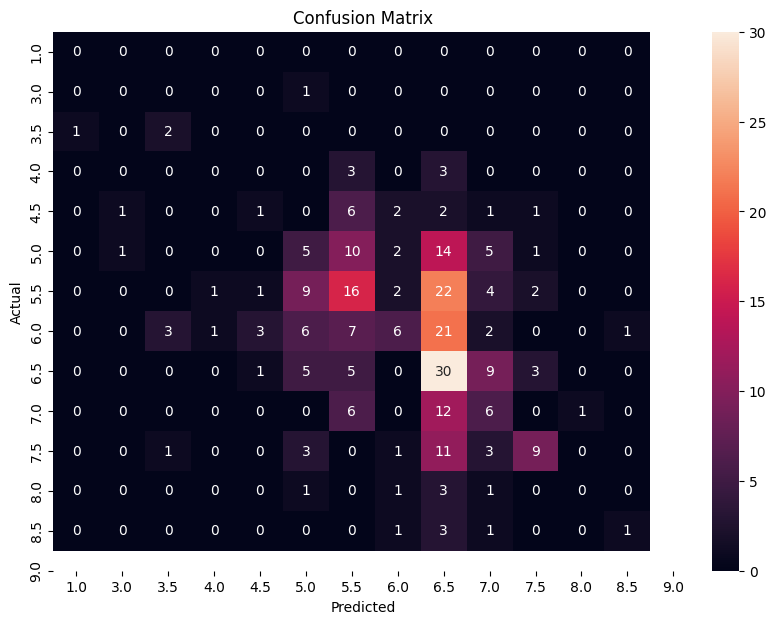

In [343]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_enc, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Predict

In [379]:
question = "Some people think students in primary or secondary school should be taught how to manage money because it is an important life skill. Do you agree or disagree?"

In [380]:
answer = "Many commentators imagine that schools should integrate financial management into their curricular. To agree with this notion, I will discuss my views in the essay below. To begin with, the supporters of teaching students how to manage money argue that learning this skill early can help to reduce reckless spending later on in life. I agree with this sentiment because some of the people who bemoan being broke are just victims of financial illiteracy. Once they receive their salaries, they easily fall into the trap of irresponsible consumerism, as in the case of many gamblers. The importance of getting an early education has thus been echoed by several gambling providers while encouraging responsible practice from their customers. In addition, the knowledge of money and how to use it responsibly can help the students to become good stewards in other parts of their lives. Financial literacy teaches vital skills in saving, humility, discipline, and delayed gratification, all of which are transferrable to everyday life, in terms building good relationships and emotional maturity. While this doesn't apply to everyone, many younger soccer players with financial advisers tend to hold their income in trusts, or place it under the care of older family members; this purposeful decision, firstly, goes against the lure of fame, luxury and consumerism, secondly, demonstrates their mental stability, humility and discipline, and thirdly, usually leads to financial security upon retirement. In conclusion, wanting students in primary or secondary school to learn how to manage money is a reasonable aspiration. I agree with this view because financial education not only leads to responsible monetary use in later life, but also shapes the students to become good, humble and disciplined citizens."

In [381]:
import numpy as np
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_ielts_score(question, answer, actual_score=None, plot=True):
    """
    Predict IELTS Writing score for a given question and essay, and optionally plot probability distribution.

    Parameters:
        question (str): The IELTS question.
        answer (str): The essay/answer text.
        actual_score (float, optional): The true IELTS score for comparison.
        plot (bool): Whether to plot a bar chart of probabilities.

    Returns:
        rounded_score (float): Predicted IELTS score rounded to nearest 0.5.
        y_pred_prob (np.ndarray): Probability distribution over all possible scores.
    """

    # Preprocess text like during training
    text = (question + ' ' + answer).lower()
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)      # remove digits

    # Tokenize and pad
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')

    # Predict probabilities
    y_pred_prob = model.predict(padded, verbose=0)[0]  # shape (num_classes,)

    # Map predicted probabilities to actual score values
    score_values = np.array([float(s) for s in le.classes_])
    predicted_score = score_values[np.argmax(y_pred_prob)]

    # Round to nearest 0.5
    rounded_score = round(predicted_score * 2) / 2

    if actual_score is not None:
        print(f"Predicted IELTS Writing Score: {rounded_score:.1f}")
        print(f"Actual IELTS Writing Score: {actual_score}")

    # Plot probability distribution
    if plot:
        plt.figure(figsize=(10, 5))
        plt.bar(score_values, y_pred_prob, width=0.4, color='#e11d48', alpha=0.7)
        plt.xlabel("IELTS Score")
        plt.ylabel("Probability")
        plt.title("Predicted Probability Distribution for IELTS Scores")
        if actual_score is not None:
            plt.axvline(actual_score, color='blue', linestyle='--', label='Actual Score')
            plt.legend()
        plt.xticks(score_values)
        plt.show()

    return rounded_score, y_pred_prob



Predicted IELTS Writing Score: 7.0
Actual IELTS Writing Score: 6.0


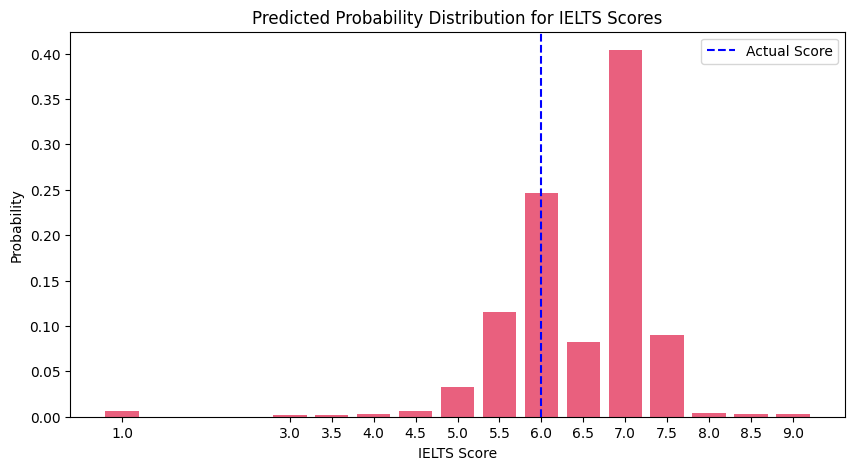

(7.0,
 array([0.00665594, 0.00160216, 0.00186514, 0.00269977, 0.00631402,
        0.03268126, 0.11577834, 0.24661802, 0.08221806, 0.40381324,
        0.08954152, 0.00405993, 0.00289278, 0.00325976], dtype=float32))

In [382]:
predict_ielts_score(question, answer, 6.0)

In [383]:
question = "It is important for everyone, including young people, to save money for their future. To what extent do you agree or disagree with this statement?"
answer = "In the modern world, it is believed that financial reserves are essential for every individual including youngsters. Personally, I totally agree with this statement for some reasons mentioned in this essay.On the one hand, savings play an essential role in personal development, especially for young people. Firstly, learning to set money aside helps to enhance financial management ability. People who save money often gradually develop the mindset of spending and investing in smart ways, which makes them  better at financial management and might avoid unnecessary expenses. In addition, owning an amount of reserved money allows them to have more freedom and confidence. This is because financially independent individuals do not have to rely on anyone so they can make their own choice and pursue their desired life. On the other hand, financial planning may be useful in many situations. First of all, having an emergency fund is very helpful in urgent cases like being sacked, being sick or helping family and friends. In fact, according to some surveys, about 40% of employees do not have any savings, which makes them have to lend or sell their properties to handle unexpected situations which often leads to a huge financial burden later. Last but not least, accumulated savings are necessary for long-term goals in a person’s life like studying abroad, purchasing valuable assets like a house, or a car or getting married and having children. Without a life-long plan for financial reserves, it is very hard for an ordinary person to achieve all those things.To sum up, I hold a firm belief that reserving a partial income is vital for everyone in all aspects, including self-enhancement and attaining personal goals."

Predicted IELTS Writing Score: 7.0
Actual IELTS Writing Score: 9.0


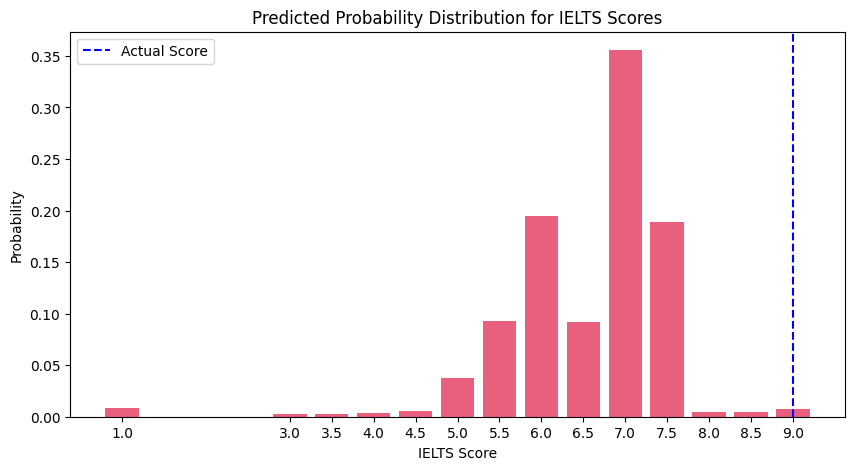

(7.0,
 array([0.00803946, 0.00258537, 0.00250426, 0.0039252 , 0.00561467,
        0.03727318, 0.09283178, 0.19501325, 0.09196382, 0.35562316,
        0.18850082, 0.00466394, 0.00439658, 0.00706452], dtype=float32))

In [384]:
predict_ielts_score(question, answer, 9.0)

In [385]:
question = "Many people believe that the best way to protect the environment is for governments to impose strict laws on industries and individuals. Others think there are better ways to encourage environmental protection. Discuss both views andgive your opinion."
answer = "There is an ongoing debate about whether governments should rely primarily on strict laws to protect the environment or adopt other approaches. While legal regulation plays an important role in controlling environmental damage, I believe that education should be prioritised as a more effective long-term solution. On the one hand, imposing strict laws is the most direct way for governments to address environmental problems. Environmental degradation often involves negative externalities, meaning that companies may ignore their environmental responsibilities in order to reduce production costs. Since voluntary environmental protection cannot cover all highly polluting industries, it is necessary for governments to introduce strict laws and emission standards. By imposing punishments and production bans, the cost of illegal activities is increased, which can force enterprises and individuals to change their behaviour. Therefore, legal measures are particularly effective in achieving short-term control and compliance. On the other hand, relying solely on laws is unlikely to provide a lasting solution. Although strict regulations may deter serious violations, compliance is often motivated by fear of punishment rather than genuine awareness. Once supervision is weakened, environmentally harmful behaviour may reappear. Moreover, many environmental problems stem from individuals’ daily habits, which cannot be effectively changed through occasional sanctions. According to an investigation conducted in Shanghai, students who receive regular environmental education engage in around 40% fewer environmentally harmful behaviours than those who do not. This suggests that education addresses the root causes of environmental degradation by shaping long-term behaviour. In conclusion, although strict environmental laws remain necessary for controlling serious violations, they should not be regarded as the primary strategy. Education plays a more decisive role in encouraging environmental protection because it targets underlying behavioural causes and produces lasting change. Therefore, governments should prioritise educational approaches, while using legal measures as a supporting tool rather than the main solution."

Predicted IELTS Writing Score: 7.5
Actual IELTS Writing Score: 7.0


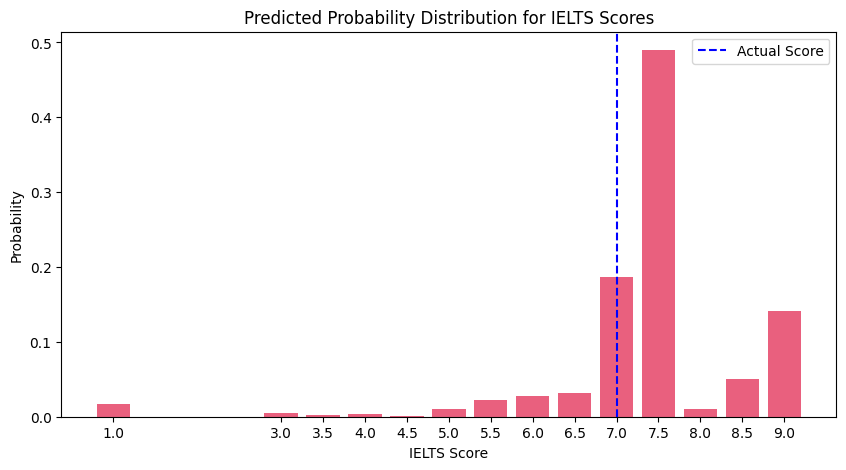

(7.5,
 array([0.01744189, 0.00472669, 0.00258065, 0.00366724, 0.00156401,
        0.00976102, 0.02253112, 0.02703615, 0.03215456, 0.18716717,
        0.48987445, 0.01037098, 0.04999502, 0.14112902], dtype=float32))

In [386]:
predict_ielts_score(question, answer, 7.0)

In [311]:
# Save model
model.save('ielts_model_2.h5')

In [ ]:
# Load model later
from tensorflow.keras.models import load_model
loaded_model = load_model('ielts_model_2.h5')